## Create the biomass map in Mexico region

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import glob
import os
import pickle
import random

import dask
import dask.array as da
import geopandas
import learn2map.raster_tools as rt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import tensorflow as tf
import xarray as xr
from a2105_global100.ml_functions import (
    data_cnn_prediction,
    densenet_model,
    density_scatter_plot,
    load_tf,
    regression_tfrecord_from_df,
    residual2_box_plot,
    residual_box_plot,
)
from geocube.api.core import make_geocube
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from tqdm import tqdm

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

os.environ["GDAL_MAX_DATASET_POOL_SIZE"] = "999"

s3_path = "s3://datayyang/data/global_biomass_100m/mexico_agb"
os.chdir("./data/gedi_1km")

Num GPUs Available:  1


## define the function

In [3]:
def raster_adding_yxgrid(
    darr,
    y_lat,
    x_lon,
    block_info=None,
):
    id_y = block_info[0]["array-location"][1]
    id_x = block_info[0]["array-location"][2]
    # x0, _ = geotfm * [np.arange(id_x[0], id_x[1]) + 0.5, 0.5]
    # _, y0 = geotfm * [0.5, np.arange(id_y[0], id_y[1]) + 0.5]
    x0 = x_lon[id_x[0] : id_x[1]]
    y0 = y_lat[id_y[0] : id_y[1]]
    xv, yv = np.meshgrid(x0, y0)
    img_stack = np.concatenate([darr, yv[None, :, :], xv[None, :, :]], axis=0)
    return img_stack


def mosaic_adding_yxgrid(xarr0, chunk_size=3000):
    xarr0 = xarr0.chunk(chunks=(xarr0.shape[0], chunk_size, chunk_size))
    out_chunks = (xarr0.shape[0] + 2, xarr0.chunks[1], xarr0.chunks[2])
    darr_out = xarr0.data.map_blocks(
        raster_adding_yxgrid,
        xarr0.y.values,
        xarr0.x.values,
        chunks=out_chunks,
        meta=np.array(()),
    )
    new_coords = [
        ("band", xarr0.band.values.tolist() + ["y_grid", "x_grid"]),
        ("y", xarr0.y.values),
        ("x", xarr0.x.values),
    ]
    xarr_out = xr.DataArray(darr_out, coords=new_coords, dims=xarr0.dims)
    return xarr_out


def extract_training_lst(
    i,
    tiles0,
    tiles1,
    scale=1,  # scale is the size ratio of tiles1 vs. tiles0
    width=1,
    valid_range=(0, 9999),
    mask_band=0,
    target_bands=[0],
    out_path=None,
):
    dims0 = tiles0.shape
    dims1 = tiles1.shape
    # print(dims0)
    # print(dims1)
    n_arr = np.arange(dims0[1] * dims0[2])
    mask_arr = tiles0[mask_band, :, :]
    mask_arr = np.where((mask_arr > valid_range[0]) & (mask_arr < valid_range[1]), 1, 0)
    valid_idx = n_arr[mask_arr.ravel().astype(bool)]

    if len(valid_idx) > 0:
        # print(len(valid_idx))
        sample0_lst = []
        sample1_lst = []
        for i in valid_idx:
            row, col = np.unravel_index(i, (dims0[1], dims0[2]))
            # print([row, col])
            sample_i = tiles0[
                :,
                row : row + 1,
                col : col + 1,
            ]
            sample0_lst.append(
                np.transpose(sample_i, [1, 2, 0])
            )  # transpose to [y, x, band]
            sample_i = tiles1[
                :,
                row * scale + width // 2 : row * scale + width * 3 // 2 + 1,
                col * scale + width // 2 : col * scale + width * 3 // 2 + 1,
            ]
            # print(np.transpose(sample_i, [1, 2, 0]).shape)
            sample1_lst.append(
                np.transpose(sample_i, [1, 2, 0])
            )  # transpose to [y, x, band]
        valid_target = np.stack(sample0_lst, axis=0)
        valid_sample = np.stack(sample1_lst, axis=0)

        band_list = np.arange(dims0[0])
        y_bands = np.isin(band_list, target_bands)
        if y_bands.any():
            y_lst = valid_target[:, 0, 0, y_bands]

        X_lst = valid_sample[:, :, :, np.arange(dims1[0])]

        pickle.dump([X_lst, y_lst], open(f"{out_path}_{i}", "wb"))
        return f"{out_path}_{i}"
        # else:
        # X_lst = np.empty([0, width, width, len(X_bands)])
        # y_lst = np.empty([0, len(y_bands)])


def get_layers_xy(
    xarr0,
    xarr1,
    scale,
    width,
    mask_band,
    target_bands,
    valid_range=(0, 9999),
    out_path=None,
):
    # Make sure xarr0/xarr1 have the same chunks
    darr0 = da.overlap.overlap(xarr0.data, depth=(0, 0, 0), boundary="nearest")
    darr1 = da.overlap.overlap(xarr1.data, depth=(0, width, width), boundary="nearest")
    tiles0 = darr0.to_delayed().ravel()
    tiles1 = darr1.to_delayed().ravel()
    results = [
        dask.delayed(extract_training_lst)(
            i,
            tiles0[i],
            tiles1[i],
            scale=scale,
            width=width,
            valid_range=valid_range,
            mask_band=mask_band,
            target_bands=target_bands,
            out_path=out_path,
        )
        for i in range(len(tiles0))
    ]
    return results


def build_vrt_mosaic(in_file, out_file):
    in_fname = "merge_list.txt"
    with open(in_fname, "w") as f:
        f.writelines("%s\n" % i for i in in_file)
    command = f"gdalbuildvrt -overwrite -input_file_list {in_fname} {out_file}"
    print(command)
    output = os.system(command)
    print(output)

## open geotiff and save to zarr files

In [4]:
s3_path1 = "s3://ctrees-development/tmp2Sassan/mexicoSite"
vsi_path = s3_path1.replace("s3://", "/vsis3/")
vsi_path1 = s3_path.replace("s3://", "/vsis3/")

file_lst = [
    "HLS.v2.0/HLS_2020_red_30m_v2.0_mexicoSite.tif",
    "HLS.v2.0/HLS_2020_nir_30m_v2.0_mexicoSite.tif",
    "HLS.v2.0/HLS_2020_swir1_30m_v2.0_mexicoSite.tif",
    "HLS.v2.0/HLS_2020_swir2_30m_v2.0_mexicoSite.tif",
    "HLS.v2.0/HLS_2020_vi_30m_v2.0_mexicoSite.tif",
    "alos/ALOS_PALSAR_2022_HH_30m_v2.3_mexicoSite.tif",
    "alos/ALOS_PALSAR_2022_HV_30m_v2.3_mexicoSite.tif",
    "mexico_reference_100m.tif",
    "RH98_densenet_l1_rh98_mosaic_v4.tif",
]
new_lst0 = [f"{vsi_path}/{file}" for file in file_lst[0:5]]
new_lst1 = [f"{vsi_path}/{file}" for file in file_lst[5:7]]
new_lst2 = [f"{vsi_path1}/{file}" for file in file_lst[7:8]]
new_lst3 = [f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/mexico_agb/{file}" for file in file_lst[8:9]]
new_lst = [new_lst0, new_lst1, new_lst2, new_lst3]
new_lst

name_lst = ["hls_30m_mx", "alos_30m_mx", "ref_100m", "RH98_100m_mx"]
for ii in range(len(name_lst)):
    path_vrt = f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_{name_lst[ii]}.vrt"
    in_fname = f"merge_list_{name_lst[ii]}.txt"
    with open(in_fname, "w") as f:
        f.writelines("%s\n" % i for i in new_lst[ii])
    band_name = rt.build_stack_vrt(in_fname, path_vrt)

['HLS_2020_red_30m_v2.0_mexicoSite_b1', 'HLS_2020_nir_30m_v2.0_mexicoSite_b1', 'HLS_2020_swir1_30m_v2.0_mexicoSite_b1', 'HLS_2020_swir2_30m_v2.0_mexicoSite_b1', 'HLS_2020_vi_30m_v2.0_mexicoSite_b1']
['ALOS_PALSAR_2022_HH_30m_v2.3_mexicoSite_b1', 'ALOS_PALSAR_2022_HV_30m_v2.3_mexicoSite_b1']
['mexico_reference_100m_b1']
['RH98_densenet_l1_rh98_mosaic_v4_b1']


In [5]:
in_file = "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_ref_100m.vrt"
out_file = "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_ref_25m.vrt"

da0 = rioxarray.open_rasterio(in_file)
print(da0.shape)
cmmd = (
    f"gdal_translate {in_file} {out_file}  -outsize {da0.shape[2]*4} {da0.shape[1]*4}"
)
os.system(cmmd)

da1 = rioxarray.open_rasterio(out_file)
print(da1.rio.resolution())
print(da1.rio.bounds())
da1

(1, 4289, 3174)
Input file size is 3174, 4289
(0.00022457882102988534, -0.00022457882102988534)
(-89.384, 17.861125746411282, -86.53274728820459, 21.714)


<xarray.DataArray (band: 1, y: 17156, x: 12696)>
[217812576 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -89.38 -89.38 -89.38 ... -86.53 -86.53 -86.53
  * y            (y) float64 21.71 21.71 21.71 21.71 ... 17.86 17.86 17.86 17.86
    spatial_ref  int64 0
Attributes:
    _FillValue:    1
    scale_factor:  1.0
    add_offset:    0.0

In [6]:
rt.raster_clip(
    out_file, "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_hls_30m_mx.vrt", "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_hls_25m_mx.vrt"
)
rt.raster_clip(
    out_file, "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_alos_30m_mx.vrt", "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_alos_25m_mx.vrt"
)

da1 = rioxarray.open_rasterio(
    "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_hls_25m_mx.vrt", chunck=(1, 2000, 2000), lock=False
).astype("float32")
da1 = da1.fillna(np.nan)
da1.rio.write_crs("EPSG:4326", inplace=True)
ds = xr.Dataset({"da": da1})
ds.to_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_hls_25m_mx.zarr", mode="w")

da1 = rioxarray.open_rasterio(
    "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_alos_25m_mx.vrt", chunck=(1, 2000, 2000), lock=False
).astype("float32")
da1 = da1.fillna(np.nan)
da1.rio.write_crs("EPSG:4326", inplace=True)
ds = xr.Dataset({"da": da1})
ds.to_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_alos_25m_mx.zarr", mode="w")

gdalwarp -s_srs "+proj=longlat +datum=WGS84 +no_defs" -t_srs "+proj=longlat +datum=WGS84 +no_defs" -te -89.384 17.861125746411286 -86.53274728820458 21.714 -ts 12696 17156 -srcnodata nan -dstnodata nan -overwrite -multi -co COMPRESS=DEFLATE -co ZLEVEL=1 -co PREDICTOR=2 -co BIGTIFF=YES -r near -ot Float32 "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_hls_30m_mx.vrt" "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_hls_25m_mx.vrt"
gdalwarp -s_srs "+proj=longlat +datum=WGS84 +no_defs" -t_srs "+proj=longlat +datum=WGS84 +no_defs" -te -89.384 17.861125746411286 -86.53274728820458 21.714 -ts 12696 17156 -srcnodata nan -dstnodata nan -overwrite -multi -co COMPRESS=DEFLATE -co ZLEVEL=1 -co PREDICTOR=2 -co BIGTIFF=YES -r near -ot Float32 "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_alos_30m_mx.vrt" "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_alos_25m_mx

Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_

In [7]:
#path_dem = "/vsis3/ctrees-input-data/digital_elevation_model/copernicus_GLO30/vrt/Copernicus_DEM_25m.vrt"
#rt.raster_clip(out_file, path_dem, "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_dem_25m_mx.vrt")

da1 = rioxarray.open_rasterio(
    "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_dem_25m_mx.vrt", chunck=(1, 2000, 2000), lock=False
).astype("float32")
da1 = da1.fillna(np.nan)
da1.rio.write_crs("EPSG:4326", inplace=True)
ds = xr.Dataset({"da": da1})
ds.to_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_dem_25m_mx.zarr", mode="w")

da1 = rioxarray.open_rasterio(
    "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_ref_100m.vrt", chunck=(1, 2000, 2000), lock=False
).astype("float32")
da1 = da1.fillna(np.nan)
da1.rio.write_crs("EPSG:4326", inplace=True)
ds = xr.Dataset({"da": da1})
ds.to_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_ref_100m_mx.zarr", mode="w")

Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_creat

In [8]:
out_file = "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_ref_25m.vrt"
rt.raster_clip(
    out_file, "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_RH98_100m_mx.vrt", "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_rh98_25_mx.vrt"
)

da1 = rioxarray.open_rasterio(
    "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_dem_25m_mx.vrt", chunck=(1, 2000, 2000), lock=False
).astype("float32")
da1 = da1.fillna(np.nan)
da1.rio.write_crs("EPSG:4326", inplace=True)
ds = xr.Dataset({"da": da1})
ds.to_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_rh98_25m_mx.zarr", mode="w")

gdalwarp -s_srs "+proj=longlat +datum=WGS84 +no_defs" -t_srs "+proj=longlat +datum=WGS84 +no_defs" -te -89.384 17.861125746411286 -86.53274728820458 21.714 -ts 12696 17156 -srcnodata nan -dstnodata nan -overwrite -multi -co COMPRESS=DEFLATE -co ZLEVEL=1 -co PREDICTOR=2 -co BIGTIFF=YES -r near -ot Float32 "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_RH98_100m_mx.vrt" "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_rh98_25_mx.vrt"


Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.
Warning 1: PROJ: internal_proj_creat

In [9]:
path_csv = f"{s3_path}/mexico.csv"
df1 = pd.read_csv(path_csv)
gdf1 = geopandas.GeoDataFrame(
    df1, geometry=geopandas.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326"
)
ref_tif = f"{s3_path}/mexico_reference_100m.tif"
da1_ref = xr.open_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_ref_100m_mx.zarr")["da"]
da0 = rioxarray.open_rasterio(ref_tif)
da1 = make_geocube(
    vector_data=gdf1,
    measurements=["agb"],
    like=da0,
)["agb"]
da1 = da1.expand_dims({"band": ["target"]}, axis=0)
da1["y"] = da1_ref.y.values
da1["x"] = da1_ref.x.values
da1 = da1.fillna(np.nan)

z1_file = "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_agb_mx.zarr"
ds = xr.Dataset({"da": da1})
ds.to_zarr(z1_file, mode="w")

In [10]:
da1_ref = xr.open_zarr(z1_file)["da"]
da1_ref

<xarray.DataArray 'da' (band: 1, y: 4289, x: 3174)>
dask.array<open_dataset-da, shape=(1, 4289, 3174), dtype=float64, chunksize=(1, 269, 397), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 'target'
    spatial_ref  int64 ...
  * x            (x) float64 -89.38 -89.38 -89.38 ... -86.53 -86.53 -86.53
  * y            (y) float64 21.71 21.71 21.71 21.71 ... 17.86 17.86 17.86 17.86
Attributes:
    long_name:  agb
    name:       agb

In [11]:
ds1 = xr.open_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_hls_25m_mx.zarr")["da"].chunk(
    [-1, 2000, 2000]
)
ds2 = xr.open_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_rh98_25m_mx.zarr")["da"].chunk(
    [-1, 2000, 2000]
)
ds2["x"] = ds1.x.values
ds2["y"] = ds1.y.values
ds3 = xr.open_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_dem_25m_mx.zarr")["da"].chunk(
    [-1, 2000, 2000]
)
ds3["x"] = ds1.x.values
ds3["y"] = ds1.y.values
# Concatenate along a dimension, for example, 'band'
combined_ds = xr.concat([ds1, ds2, ds3], dim="band")
combined_ds = combined_ds.rio.write_crs("EPSG:4326")
combined_ds = combined_ds.chunk([-1, 2000, 20000])
combined_ds.attrs = {}
# Save the combined dataset back to a Zarr dataset
ds = xr.Dataset({"da": combined_ds})
del ds.da.encoding["chunks"]
ds.to_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/xlayers_combine_25m_noalos.zarr", mode="w")
ds

ERROR 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.


<xarray.Dataset>
Dimensions:      (band: 7, x: 12696, y: 17156)
Coordinates:
  * band         (band) int64 1 2 3 4 5 1 1
  * x            (x) float64 -89.38 -89.38 -89.38 ... -86.53 -86.53 -86.53
  * y            (y) float64 21.71 21.71 21.71 21.71 ... 17.86 17.86 17.86 17.86
    spatial_ref  int64 0
Data variables:
    da           (band, y, x) float32 dask.array<chunksize=(7, 2000, 12696), meta=np.ndarray>

In [12]:
ds2
ds3

<xarray.DataArray 'da' (band: 1, y: 17156, x: 12696)>
dask.array<rechunk-merge, shape=(1, 17156, 12696), dtype=float32, chunksize=(1, 2000, 2000), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * x        (x) float64 -89.38 -89.38 -89.38 -89.38 ... -86.53 -86.53 -86.53
  * y        (y) float64 21.71 21.71 21.71 21.71 ... 17.86 17.86 17.86 17.86
Attributes:
    grid_mapping:  spatial_ref

In [13]:
da1 = xr.open_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/xlayers_combine_25m_noalos.zarr")["da"].chunk([-1, 2000, 2000])
da2 = xr.open_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_rh98_25m_mx.zarr")["da"].chunk(
    [-1, 2000, 2000]
)
da2["x"] = da1.x.values
da2["y"] = da1.y.values

combined_ds = xr.concat([da1, da2], dim="band")
combined_ds = combined_ds.rio.write_crs("EPSG:4326")
combined_ds = combined_ds.chunk([-1, 2000, 20000])
combined_ds.attrs = {}
# Save the combined dataset back to a Zarr dataset
ds = xr.Dataset({"da": combined_ds})
del ds.da.encoding["chunks"]
ds.to_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/xlayers_combine_25m_cnn.zarr", mode="w")
ds

ERROR 1: PROJ: internal_proj_create_from_database: /Users/stephaniegeorge/miniforge3/envs/ctrees-dev/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 0 whereas a number >= 2 is expected. It comes from another PROJ installation.


<xarray.Dataset>
Dimensions:      (band: 8, x: 12696, y: 17156)
Coordinates:
  * band         (band) int64 1 2 3 4 5 1 1 1
  * x            (x) float64 -89.38 -89.38 -89.38 ... -86.53 -86.53 -86.53
  * y            (y) float64 21.71 21.71 21.71 21.71 ... 17.86 17.86 17.86 17.86
    spatial_ref  int64 0
Data variables:
    da           (band, y, x) float32 dask.array<chunksize=(8, 2000, 12696), meta=np.ndarray>

In [15]:
ds1 = xr.open_zarr("/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_agb_mx.zarr")
ds1
# ds2 = xr.open_zarr(f"{s3_path}/test_layers_ref_100m_mx.zarr")
# ds2
# Concatenate along a dimension, for example, 'band'
# combined_ds1 = xr.concat([ds1, ds2], dim="band")

# # Save the combined dataset back to a Zarr dataset
# combined_ds1.to_zarr(f"{s3_path}/target_combine_25m.zarr")
# combined_ds1

<xarray.Dataset>
Dimensions:      (band: 1, y: 4289, x: 3174)
Coordinates:
  * band         (band) object 'target'
    spatial_ref  int64 ...
  * x            (x) float64 -89.38 -89.38 -89.38 ... -86.53 -86.53 -86.53
  * y            (y) float64 21.71 21.71 21.71 21.71 ... 17.86 17.86 17.86 17.86
Data variables:
    da           (band, y, x) float64 dask.array<chunksize=(1, 269, 397), meta=np.ndarray>

In [16]:
ds2 = xr.open_zarr(f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_ref_100m_mx.zarr")
ds2

<xarray.Dataset>
Dimensions:      (band: 1, y: 4289, x: 3174)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -89.38 -89.38 -89.38 ... -86.53 -86.53 -86.53
  * y            (y) float64 21.71 21.71 21.71 21.71 ... 17.86 17.86 17.86 17.86
Data variables:
    da           (band, y, x) float32 dask.array<chunksize=(1, 537, 397), meta=np.ndarray>
    spatial_ref  int64 ...

load X-layers(in Zarr) and set up

In [17]:
path_tif = f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_ref_100m_mx.zarr"
da0 = xr.open_zarr(path_tif)["da"]
da0

path_tif = f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_hls_25m_mx.zarr"
da1 = xr.open_zarr(path_tif)["da"]
da1
print(da0.rio.resolution())
print(da1.rio.resolution())

print(da1.shape[2] / da0.shape[2])

(0.000898315284119542, -0.0008983152841195416)
(0.00022457882102988513, -0.00022457882102988534)
4.0


extraction training/eval/test

In [18]:
outname = "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/mexico_agb/mexico_agb_noalos_"
os.makedirs(outname, exist_ok=True)

pix_size = 0.00022457882102988513
offsets = 0.00005 + pix_size * 2.5
width = 7

In [20]:
path_tif = "/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/test_layers_agb_mx.zarr"
da0 = xr.open_zarr(path_tif)["da"].chunk((-1, 1000, 1000))
da0

<xarray.DataArray 'da' (band: 1, y: 4289, x: 3174)>
dask.array<rechunk-merge, shape=(1, 4289, 3174), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 'target'
    spatial_ref  int64 ...
  * x            (x) float64 -89.38 -89.38 -89.38 ... -86.53 -86.53 -86.53
  * y            (y) float64 21.71 21.71 21.71 21.71 ... 17.86 17.86 17.86 17.86
Attributes:
    long_name:  agb
    name:       agb

In [21]:
path_tif = f"/Users/stephaniegeorge/Documents/ctrees/Projects/Mexico_AGB_30m/test/xlayers_combine_25m_noalos.zarr"
da1 = xr.open_zarr(path_tif)["da"].chunk((-1, 4000, 4000))
da1

<xarray.DataArray 'da' (band: 7, y: 17156, x: 12696)>
dask.array<rechunk-merge, shape=(7, 17156, 12696), dtype=float32, chunksize=(7, 4000, 4000), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4 5 1 1
  * x        (x) float64 -89.38 -89.38 -89.38 -89.38 ... -86.53 -86.53 -86.53
  * y        (y) float64 21.71 21.71 21.71 21.71 ... 17.86 17.86 17.86 17.86
Attributes:
    grid_mapping:  spatial_ref

In [22]:
results = get_layers_xy(
    da0,
    da1,
    scale=4,
    width=width,
    mask_band=0,
    target_bands=[0],
    valid_range=(0, 700),
    out_path=f"{outname}/training_samples",
)

computed = dask.compute(*results)

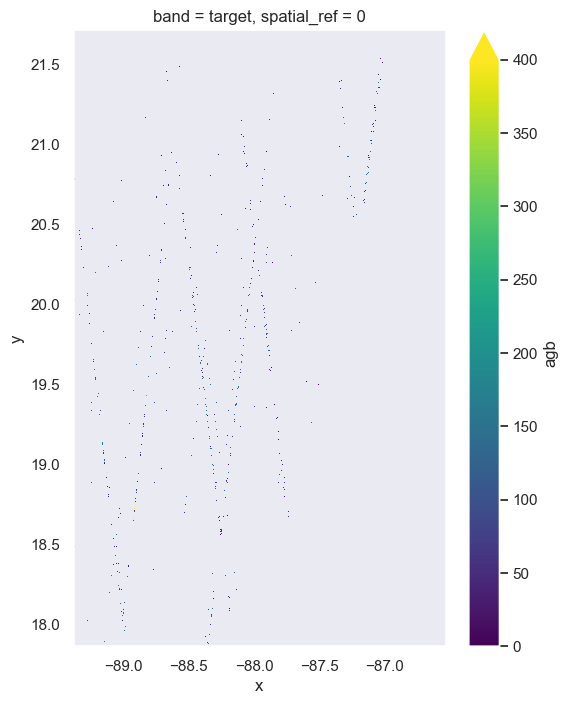

In [23]:
da0.plot(vmin=0, vmax=400, figsize=(6, 8))

In [24]:
# read data
files_15 = glob.glob(f"{outname}/training_samples*")
X_15_lst = []
y_15_lst = []
for ifile in files_15:
    X_lst, y_lst = pickle.load(open(ifile, "rb"))
    # os.remove(ifile)
    X_15_lst.append(X_lst)
    y_15_lst.append(y_lst)
X_15 = np.concatenate(X_15_lst, axis=0)
y_15 = np.concatenate(y_15_lst, axis=0)

valid_idx = ~np.isnan(X_15.reshape(X_15.shape[0], -1)).any(axis=1)
X_15 = X_15[valid_idx]
y_15 = y_15[valid_idx]

## save as tfrecords

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_15, y_15[:, 0], test_size=0.2, random_state=44
)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train, y_train, test_size=0.2, random_state=55
)

In [27]:
print(X_train.shape)
print(y_train.shape)

(19080, 8, 8, 7)
(19080,)


In [28]:
# Function to serialize a single example of features and label
def serialize_example(feature, label):
    feature = feature.flatten()  # Flatten the multi-dimensional feature to 1D
    feature_dict = {
        "features": tf.train.Feature(float_list=tf.train.FloatList(value=feature)),
        "label": tf.train.Feature(float_list=tf.train.FloatList(value=[label])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return example_proto.SerializeToString()


with tf.io.TFRecordWriter(f"{outname}/tf_training.tfrecord") as writer:
    for feature, label in zip(X_train, y_train):
        serialized_example = serialize_example(feature, label)
        writer.write(serialized_example)
with tf.io.TFRecordWriter(f"{outname}/tf_eval.tfrecord") as writer:
    for feature, label in zip(X_eval, y_eval):
        serialized_example = serialize_example(feature, label)
        writer.write(serialized_example)
with tf.io.TFRecordWriter(f"{outname}/tf_test.tfrecord") as writer:
    for feature, label in zip(X_test, y_test):
        serialized_example = serialize_example(feature, label)
        writer.write(serialized_example)

## Load training and preprocessing

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
BATCH_SIZE_TEST = 32
width = 8
nbands = 7
n_train = y_train.shape[0]

In [30]:
# Read the TFRecord file
def parse_function(example_proto):
    feature_description = {
        "features": tf.io.FixedLenFeature(
            [width * width * nbands], tf.float32
        ),  # Must match the flattened shape
        "label": tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    parsed_features["features"] = tf.reshape(
        parsed_features["features"], (width, width, nbands)
    )  # Reshape back to original shape
    return parsed_features["features"], parsed_features["label"]


train_dataset = tf.data.TFRecordDataset(f"{outname}/tf_training.tfrecord").map(
    parse_function
)
eval_dataset = tf.data.TFRecordDataset(f"{outname}/tf_eval.tfrecord").map(
    parse_function
)
test_dataset = tf.data.TFRecordDataset(f"{outname}/tf_test.tfrecord").map(
    parse_function
)

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-07-06 20:39:44.285657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-06 20:39:44.286361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
train_dataset

<MapDataset shapes: ((8, 8, 7), ()), types: (tf.float32, tf.float32)>

In [32]:
# Find mean/std of training data
SAMPLE_N = 50000
X_list = []
y_list = []
for X, Y in train_dataset.shuffle(buffer_size=200000).take(SAMPLE_N):
    X_list.append(X.numpy())
    y_list.append(Y.numpy())
X_all = np.stack(X_list, axis=0)
y_all = np.stack(y_list, axis=0)
X_mean = np.nanmean(X_all.reshape(-1, nbands), axis=0).tolist()
X_std = np.nanstd(X_all.reshape(-1, nbands), axis=0).tolist()
Y_mean = np.nanmean(y_all.reshape(-1, 1), axis=0).tolist()
Y_std = np.nanstd(y_all.reshape(-1, 1), axis=0).tolist()
print(f"X_mean: {X_mean}")
print(f"X_std: {X_std}")
print(f"y_mean: {Y_mean}")
print(f"y_std: {Y_std}")

2024-07-06 20:40:02.969446: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


X_mean: [180.4639434814453, 3193.9951171875, 1584.1929931640625, 563.2740478515625, 4164.49072265625, 42.40576934814453, 42.40576934814453]
X_std: [1125.3140869140625, 1504.6129150390625, 1303.03515625, 1177.884765625, 1622.6407470703125, 42.947837829589844, 42.947837829589844]
y_mean: [79.40812683105469]
y_std: [51.124732971191406]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 8, 7)]         0         
                                                                 
 dense_net_3 (DenseNet)      (None, 2, 2, 268)         450080    
                                                                 
 global_average_pooling2d_3   (None, 268)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 64)                17216     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 467,361
Trainable params: 447,193
Non-trainable params: 20,168
________________________________________________

2024-07-06 21:00:20.621973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - ETA: 0s - loss: 1.1696 - root_mean_squared_error: 0.9680

2024-07-06 21:00:49.356267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - 45s 194ms/step - loss: 1.1696 - root_mean_squared_error: 0.9680 - val_loss: 1.1304 - val_root_mean_squared_error: 0.9216
Epoch 2/100
149/149 [==============================] - 20s 133ms/step - loss: 1.0958 - root_mean_squared_error: 0.9256 - val_loss: 1.0793 - val_root_mean_squared_error: 0.9075
Epoch 3/100
149/149 [==============================] - 20s 131ms/step - loss: 1.0505 - root_mean_squared_error: 0.9136 - val_loss: 1.0602 - val_root_mean_squared_error: 1.0232
Epoch 4/100
149/149 [==============================] - 20s 132ms/step - loss: 1.0139 - root_mean_squared_error: 0.9300 - val_loss: 0.9839 - val_root_mean_squared_error: 0.9253
Epoch 5/100
149/149 [==============================] - 20s 132ms/step - loss: 0.9697 - root_mean_squared_error: 0.9238 - val_loss: 0.9412 - val_root_mean_squared_error: 0.9084
Epoch 6/100
149/149 [==============================] - 20s 132ms/step - loss: 0.9191 - root_mean_squared_error: 0.8898 - val_loss: 0

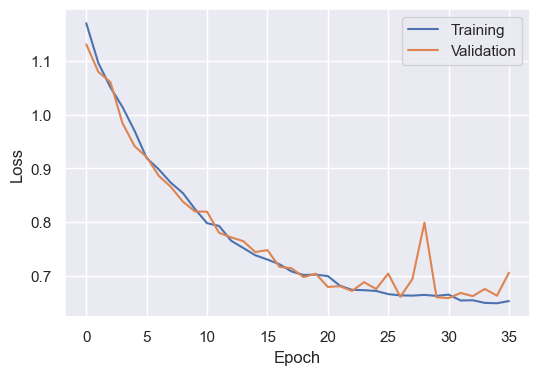

In [40]:
def batch_normalize_xy(X, Y):
    sample_mean = tf.constant([[X_mean]])
    sample_std = tf.constant([[X_std]])
    X = (X - sample_mean) / sample_std
    X = tf.where(tf.math.is_nan(X), tf.zeros_like(X), X)

    y_mean = tf.constant(Y_mean)
    y_std = tf.constant(Y_std)
    Y = (Y - y_mean) / y_std
    # Y = tf.where(tf.math.is_nan(Y), tf.ones_like(Y) * 63, Y)
    # indices = tf.constant(list(range(0,7)) + list(range(11,18)))
    # Y = tf.gather(Y, indices)
    return X, Y


ds1 = (
    train_dataset.repeat()
    .shuffle(80000)
    .batch(
        BATCH_SIZE,
    )
    .map(batch_normalize_xy, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
ds2 = (
    eval_dataset.batch(
        BATCH_SIZE_TEST,
    )
    .map(batch_normalize_xy, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

fname = f"{outname}_densenet_l1_ckpt"
dn_structure = (12, 24, 18)
epochs = 100

# tf.debugging.set_log_device_placement(True)
# strategy = tf.distribute.MirroredStrategy()
# print("Number of devices: {}".format(strategy.num_replicas_in_sync))

m = densenet_model(dn_structure, width, nbands, 1)
print(m.summary())

m.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    # loss=tf.keras.losses.get("MeanSquaredError"),
    loss=tf.keras.losses.get("MeanAbsoluteError"),
    metrics=[tf.keras.metrics.get(metric) for metric in ["RootMeanSquaredError"]],
)

# with strategy.scope():
if os.path.exists(fname):
    m.load_weights(fname)
    print("Pretrained model loaded...")
else:
    print("Building new model...")

earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    verbose=1,
    patience=5,
    restore_best_weights=True,
)

history = m.fit(
    x=ds1,
    epochs=epochs,
    callbacks=[
        earlystop_callback,
    ],
    steps_per_epoch=int(n_train / BATCH_SIZE),
    validation_data=ds2,
)
m.save_weights(fname, save_format="tf")

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(f"{fname}_history.png", dpi=300, bbox_inches="tight")
plt.show()

In [41]:
# define evaluation function
def eval_plot(
    ds_test,
    model,
    out_name,
    n_samples=None,
):
    ds2 = (
        ds_test.batch(BATCH_SIZE_TEST)
        .map(batch_normalize_xy, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

    X_list = []
    y_list = []
    for X, Y in ds2:
        X_list.append(X.numpy())
        y_list.append(Y.numpy())
    X_test = np.concatenate(X_list)
    y_test = np.concatenate(y_list)

    if n_samples is not None:
        idx_test = np.random.choice(X_test.shape[0], size=n_samples, replace=False)
        X_test = X_test[idx_test, :]
        y_test = y_test[idx_test, None]
    y_test = y_test * np.array(Y_std)[None, :] + np.array(Y_mean)[None, :]
    predictions = (
        model.predict(X_test, verbose=1) * np.array(Y_std)[None, :]
        + np.array(Y_mean)[None, :]
    )

    Parallel(n_jobs=-1)(
        delayed(density_scatter_plot)(
            y_test[:, i_test][~np.isnan(y_test[:, i_test])],
            predictions[:, i_test][~np.isnan(y_test[:, i_test])],
            file_name=f"{out_name}_xyscatter.png",
        )
        for i_test in tqdm(range(y_test.shape[1]))
    )
    Parallel(n_jobs=-1)(
        delayed(residual_box_plot)(
            y_test[:, i_test][~np.isnan(y_test[:, i_test])],
            predictions[:, i_test][~np.isnan(y_test[:, i_test])],
            outname=f"{out_name}_residual.png",
            floating=True,
        )
        for i_test in tqdm(range(y_test.shape[1]))
    )
    Parallel(n_jobs=-1)(
        delayed(residual2_box_plot)(
            y_test[:, i_test][~np.isnan(y_test[:, i_test])],
            predictions[:, i_test][~np.isnan(y_test[:, i_test])],
            outname=f"{out_name}_residual2.png",
            floating=True,
        )
        for i_test in tqdm(range(y_test.shape[1]))
    )

2024-07-06 21:12:55.231706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 5s 98ms/step


100%|██████████| 1/1 [00:00<00:00, 1265.63it/s]


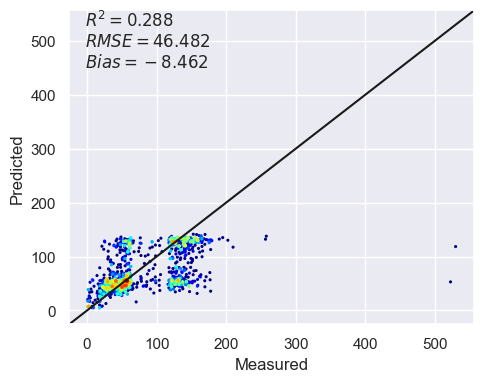

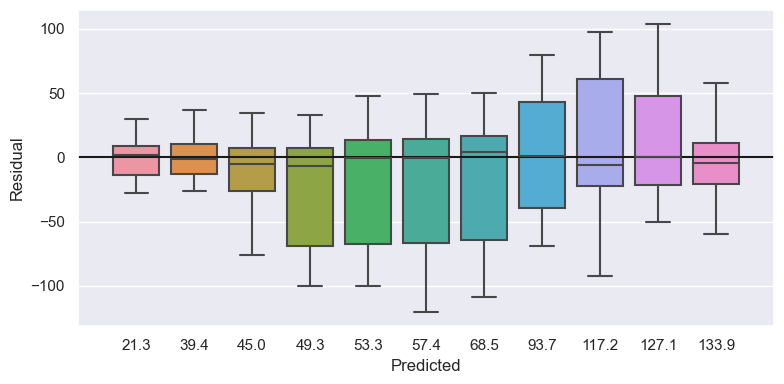

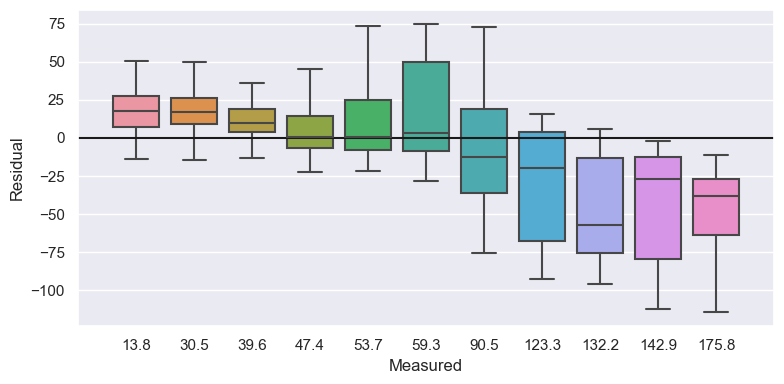

In [42]:
eval_plot(
    train_dataset,
    m,
    f"{fname}_train",
    n_samples=1000,
)

In [5]:
eval_plot(
    eval_dataset,
    m,
    f"{fname}_eval",
    n_samples=3000,
)

NameError: name 'eval_plot' is not defined

157/157 [==============================] - 3s 20ms/step


100%|██████████| 1/1 [00:00<00:00, 731.48it/s]


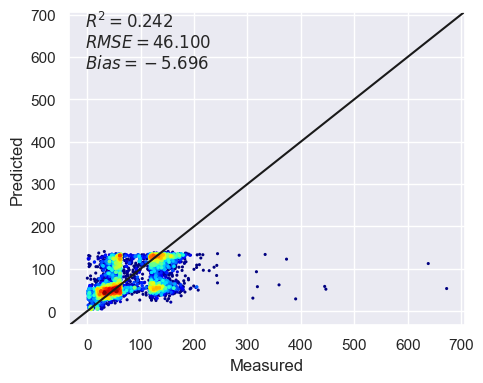

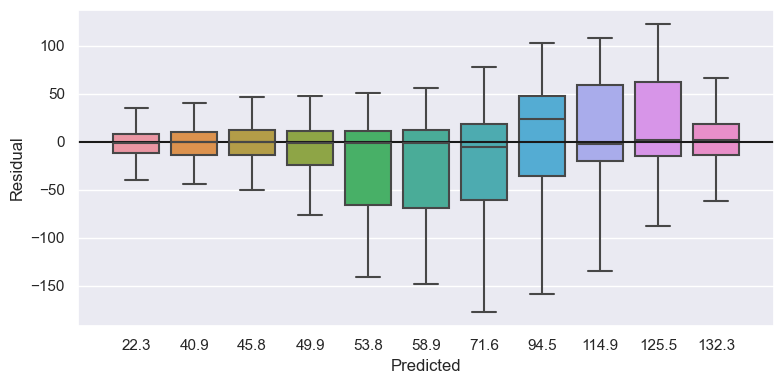

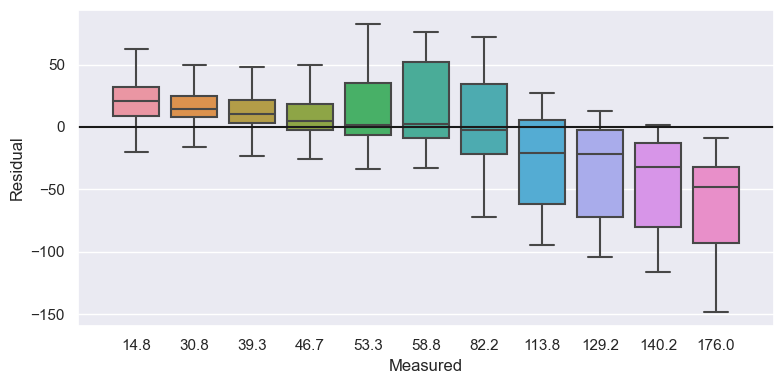

In [44]:
eval_plot(
    test_dataset,
    m,
    f"{fname}_test",
    n_samples=5000,
)

## Prediction

In [4]:
width = 8
bands = list(range(9))
chunk_size = 800
mask_band = 7

dn_structure = (12, 24, 18)
fname = f"{outname}_densenet_l1_ckpt"

m = densenet_model(dn_structure, width, nbands, 1)
m.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.get("MeanAbsoluteError"),
    metrics=[tf.keras.metrics.get(metric) for metric in ["RootMeanSquaredError"]],
)
m.load_weights(fname)

NameError: name 'outname' is not defined

In [2]:
def build_vrt_mosaic(in_file, out_file):
    in_fname = "merge_list.txt"
    with open(in_fname, "w") as f:
        f.writelines("%s\n" % i for i in in_file)
    command = f"gdalbuildvrt -overwrite -input_file_list {in_fname} {out_file}"
    print(command)
    output = os.system(command)
    print(output)


def yprep_model(Y):
    y_mean = np.array(Y_mean)
    y_std = np.array(Y_std)
    Y = Y * y_std[None, :] + y_mean[None, :]
    return Y


def xprep_model(X):
    sample_mean = np.array(X_mean)
    sample_std = np.array(X_std)
    X = (X - sample_mean[None, :]) / sample_std[None, :]
    X = np.where(np.isnan(X), np.zeros_like(X), X)
    X = X[:, :]
    return X

In [3]:
os.makedirs(f"{outname}_densenet_l1", exist_ok=True)
out_prefix = f"{outname}_densenet_l1/pred"

ij_lst = [
    (i, j)
    for i in range(np.ceil(da1.shape[1] / chunk_size).astype(int))
    for j in range(np.ceil(da1.shape[2] / chunk_size).astype(int))
]
random.shuffle(ij_lst)

# Parallel(n_jobs=2)(
Parallel(n_jobs=1, prefer="threads")(
    delayed(data_cnn_prediction)(
        ij,
        chunk_size,
        path_tif,
        m,
        yprep_model,
        xprep_model,
        bands=bands,
        mask_band=mask_band,
        nbands_out=1,
        patchsize=(width, width),
        strides=(4, 4),
        scale=10,
        crs="EPSG:4326",
        withxy=False,
        out_name=out_prefix,
    )
    for ij in tqdm(ij_lst)
)

NameError: name 'os' is not defined

In [ ]:
out_file = f"{outname}_densenet_l1_rh98_mosaic.vrt"
flist = f"{outname}_densenet_l1/pred*.tif"
in_file = glob.glob(flist)
build_vrt_mosaic(in_file, out_file)

cog_file = f"{outname}_densenet_l1_rh98_mosaic.tif"
cmmd = (
    f"gdal_translate {out_file} {cog_file} -of COG -co BIGTIFF=YES -co COMPRESS=DEFLATE "
    f"-co PREDICTOR=2 -co NUM_THREADS=16 -ot Int16"
)
os.system(cmmd)

"""
cmmd = (
    f"aws s3 cp {outname}_densenet_l1_rh98_mosaic.tif "
    f"{s3_path}{outname}_densenet_l1_rh98_mosaic.tif"
)
os.system(cmmd)
"""